In [1]:
import matplotlib.pyplot as plt
import itertools as it
import numpy as np
import os

In [2]:
plt.rcParams['axes.facecolor']='white'
plt.rcParams.update({'font.size': 8})
plt.rc('font', family='Helvetica')

In [3]:
def cyclic_permutation(arr):
    arr = list(it.permutations(arr))
    for a1 in arr:
        for a2 in arr:
            if a1 != a2:
                for i in range(1,len(a1)+1):
                    if (np.roll(a1,i) == a2).all():
                        arr.remove(a2)
    return arr

def aspace(start, stop, spacing, decimals=3):
    space = np.linspace(start, stop, int(round((stop - start)/spacing ,2)+1))
    rounded_space = np.around(space, decimals=decimals)
    return rounded_space

## Loading phase data

Each file contains a phase space plot for a particular sequence of patterns

Input: .npy files saved as .interpolation_data/n=$n$/sector/activity_a1=$a_1$\_a2=$a_2$\_a3=$a_3$\_a4=$a_4$\_a5=$a_5$/nettype=$net$\_phase\_space.npy for each permutation of the set of activities.

In [6]:
thresh = 0.8
interpolation_step = 3

d = {}
names = ["SK", "HU", "MAI", "MSI"]
d_inter = {}
for interpolation_step in range(0,6):
    d_inter[interpolation_step] = {}
    d[interpolation_step] = {}
    for net in names:
        arr = []
        activities = np.array([0.3, 0.3, 0.3, 0.3, 0.3])
        activity_str = f"activity_a1=%s_a2=%s_a3=%s_a4=%s_a5=%s" % tuple(activities)
        PATH = f"interpolation_data/n=0/{activity_str}"
        phase_space_dict = np.load(os.path.join(PATH, f"nettype={net}_phase_space.npy"), allow_pickle=True).item()

        (theta_min, theta_max) = phase_space_dict["theta"]
        (gamma_min, gamma_max) = phase_space_dict["gamma"]
                
        phase_space = phase_space_dict["phase_space"]
        phase_space[np.isnan(phase_space)] = 0
        phase_space[phase_space < thresh] = 0
        phase_space[phase_space > thresh] = 1
        d[interpolation_step][net] = phase_space

        start_activities_set = np.array([0.3, 0.3, 0.3, 0.3, 0.3])
        end_activities_set = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
        num_interpolation_steps = 6
        activities_set = start_activities_set + \
                        (end_activities_set - start_activities_set)* \
                        interpolation_step/(num_interpolation_steps-1)

        activities_set = np.around(activities_set, decimals=2)
        perms = cyclic_permutation(activities_set)

        ps_temp = np.zeros_like(phase_space)
        for idx, perm in enumerate(perms):
            if idx >= 24:
                break
            activities = perm
            activity_str = f"activity_a1=%s_a2=%s_a3=%s_a4=%s_a5=%s" % tuple(activities)
            PATH = f"interpolation_data/n={interpolation_step}/{activity_str}"
            phase_space_dict = np.load(os.path.join(PATH, f"nettype={net}_phase_space.npy"), allow_pickle=True).item()

            (theta_min, theta_max) = phase_space_dict["theta"]
            (gamma_min, gamma_max) = phase_space_dict["gamma"]

            phase_space = phase_space_dict["phase_space"]
            phase_space[np.isnan(phase_space)] = 0
            phase_space[phase_space < thresh] = 0
            phase_space[phase_space > thresh] = 1

            
            if net == "HU" and interpolation_step == 5:
                ps_temp[:199] += phase_space[:199]

            
            else:
                ps_temp += phase_space
                

        gt_spacing = phase_space_dict["gt_spacing"]

        ps_temp = ps_temp/24

        d_inter[interpolation_step][net] = (ps_temp, gamma_min, gamma_max, theta_min, theta_max, gt_spacing)

## Plotting phase data (see manuscript for axis labels)

/var/folders/m6/d33f9cts3cnglkrymdy1gxxh0000gn/T/ipykernel_16128/22415349.py:41: UserWarning: No contour levels were found within the data range.
  C = ax.contour(contour.T, levels=0, alpha=1,
/var/folders/m6/d33f9cts3cnglkrymdy1gxxh0000gn/T/ipykernel_16128/22415349.py:41: UserWarning: The following kwargs were not used by contour: 'interpolation'
  C = ax.contour(contour.T, levels=0, alpha=1,


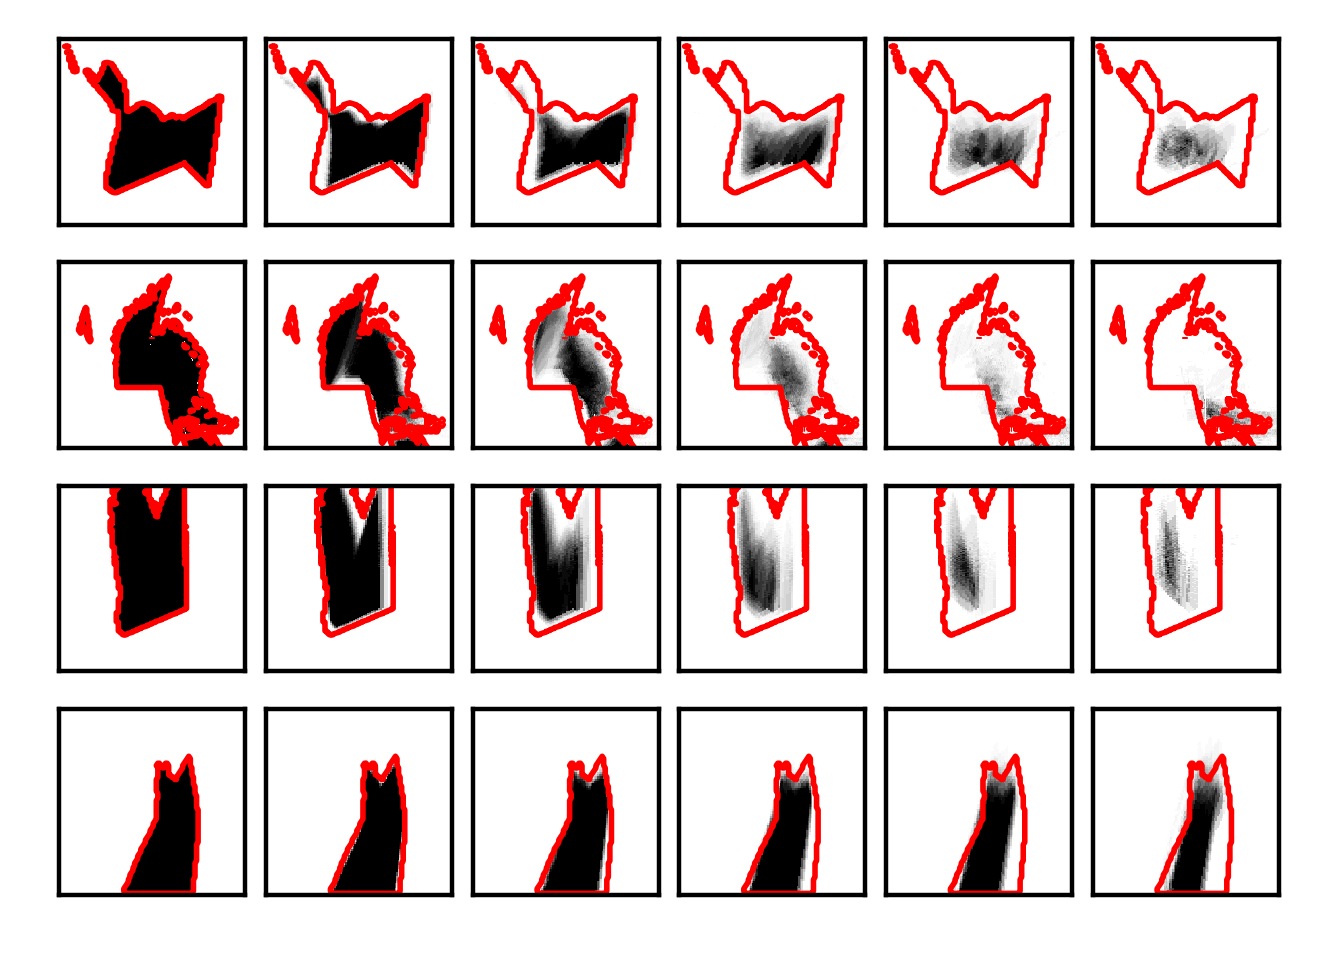

In [5]:
phase_range_dict={
                "SK": [(-0.2, 0.7), (0,3)],
                "MAI": [(-0.2, 0.7), (0,3)],
                "MSI": [(-0.3, 0.3), (0,0.4)],
                "HU": [(-0.4, 1.4), (0,1.3)]
                 }

phase_tick_labels={
                "SK": ([0, 0.5], [0,1,2,3]),
                "MAI": ([0, 0.5],[0,1,2,3]),
                "MSI": ([-0.2,0,0.2],[0,0.3]),
                "HU": ([0,1],[0,1])
                 }

fig = plt.figure(figsize=(4,4.72*0.6), dpi=400)
c = 0
for i, net in enumerate(d[5].keys()):

    for interpolation_step in range(0,6):
        ax = fig.add_subplot(4,6,c+1)
        (ps,  gamma_min, gamma_max, theta_min, theta_max, gt_spacing) = d_inter[interpolation_step][net]
        contour = d[interpolation_step][net]

        [(t_min, t_max), (g_min, g_max)] = phase_range_dict[net]    
        t_range = aspace(t_min, t_max, gt_spacing)
        theta_range = aspace(theta_min, theta_max, gt_spacing)
        g_range = aspace(g_min, g_max, gt_spacing)
        gamma_range = aspace(gamma_min, gamma_max, gt_spacing)
        (_, _, g_indices) = np.intersect1d(g_range, gamma_range, return_indices=True)
        (_, _, t_indices) = np.intersect1d(t_range, theta_range, return_indices=True)
        ps = ps[min(t_indices):max(t_indices),min(g_indices):max(g_indices)]
        contour = contour[min(t_indices):max(t_indices),min(g_indices):max(g_indices)]
        
        [(theta_min, theta_max), (gamma_min, gamma_max)] = phase_range_dict[net]
        extent = [theta_min, theta_max, gamma_min, gamma_max]
                
        ax.imshow(ps.T, aspect="auto", 
                                 extent=extent, 
                                 alpha=1, vmin=0, cmap='Greys', origin="lower", interpolation='none')

        C = ax.contour(contour.T, levels=0, alpha=1, 
                      origin='lower', cmap='flag', 
                      extend='both', linewidths=1, extent=extent,
                    zorder=1, antialiased=True, interpolation="nearest")
        
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.tick_params(axis='both', which='minor', labelsize=8)
        ax.set_box_aspect(1)
        
        if c > 8:
            ax.set_xlabel(r"$\theta$", size=8)
        if c % 6 != 0:
            ax.set_yticks([])
            ax.set_yticklabels([])
        else:            
            ax.set_ylabel(r"$\lambda$", size=8)
            ax.set_yticks(ticks=phase_tick_labels[net][1])
            ax.set_yticklabels(phase_tick_labels[net][1])
            ax.tick_params(axis='both', which='major', labelsize=8)

        ax.set_xticks(ticks=phase_tick_labels[net][0])
        ax.set_xticklabels(phase_tick_labels[net][0])
        ax.tick_params(axis='both', which='major', labelsize=8)
        c += 1
    
        ax.set_yticks([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_xlabel(r"", size=8)
        ax.set_ylabel(r"", size=8)


        
fig.subplots_adjust(wspace=0,hspace=0.2)
fig.align_ylabels()


## Loading retrieval for varying unevenness parameter 

In [6]:
thresh_arr = []
threshs = [0.8]

for thresh in threshs:
    d = {}
    names = ["SK", "HU", "MAI", "MSI"]
    c = 0
    for net in names:
        arr = []
        activities = np.array([0.3, 0.3, 0.3, 0.3, 0.3])
        activity_str = f"activity_a1=%s_a2=%s_a3=%s_a4=%s_a5=%s" % tuple(activities)
        PATH = f"interpolation_data/n=0/{activity_str}"
        phase_space_dict = np.load(os.path.join(PATH, f"nettype={net}_phase_space.npy"), allow_pickle=True).item()

        (theta_min, theta_max) = phase_space_dict["theta"]
        (gamma_min, gamma_max) = phase_space_dict["gamma"]
        phase_space = phase_space_dict["phase_space"]
        phase_space[np.isnan(phase_space)] = 0
        thresh_1 = thresh
        phase_space[phase_space < thresh_1] = 0
        phase_space[phase_space > thresh_1] = 1
        arr.append(int(sum(phase_space.ravel())))
        d[net] = np.array(arr)
        
    d_inter = {}
    for interpolation_step in range(6):
        d_inter[interpolation_step] = {}
        start_activities_set = np.array([0.3, 0.3, 0.3, 0.3, 0.3])
        end_activities_set = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
        num_interpolation_steps = 6
        activities_set = start_activities_set + (end_activities_set - start_activities_set)*interpolation_step/(num_interpolation_steps-1)
        activities_set = np.around(activities_set, decimals=2)
        perms = cyclic_permutation(activities_set)
        activity_iter = iter(perms)
        c = 0
        for i in range(2):
            for j in range(2):
                arr = []
                for idx, perm in enumerate(perms):
                    if idx >= 24:
                        break
                    activities = perm
                    activity_str = f"activity_a1=%s_a2=%s_a3=%s_a4=%s_a5=%s" % tuple(activities)
                    PATH = f"interpolation_data/n={interpolation_step}/{activity_str}"
                    phase_space_dict = np.load(os.path.join(PATH, f"nettype={names[c]}_phase_space.npy"), allow_pickle=True).item()

                    (theta_min, theta_max) = phase_space_dict["theta"]
                    (gamma_min, gamma_max) = phase_space_dict["gamma"]
                    phase_space = phase_space_dict["phase_space"]
                    phase_space[np.isnan(phase_space)] = 0
                    phase_space[phase_space < thresh] = 0
                    phase_space[phase_space > thresh] = 1
                    arr.append(int(sum(phase_space.ravel())))
                arr = np.divide(arr, d[names[c]])
                d_inter[interpolation_step][names[c]] = [np.mean(arr), np.std(arr)]
                c += 1

    master_arr = []
    master_std = []
    for interpolation_step, d_nets in d_inter.items():
        arr = []
        std_arr = []
        for net, [mean, std] in d_nets.items():
            arr.append(mean)
            std_arr.append(std)
        master_arr.append(arr)
        master_std.append(std_arr)

    master_arr = np.array(master_arr, dtype=float)
    master_std = np.array(master_std, dtype=float)

    thresh_arr.append((master_arr, master_std))


## Plotting retrieval for varying unevenness parameter

(0.0, 1.0)

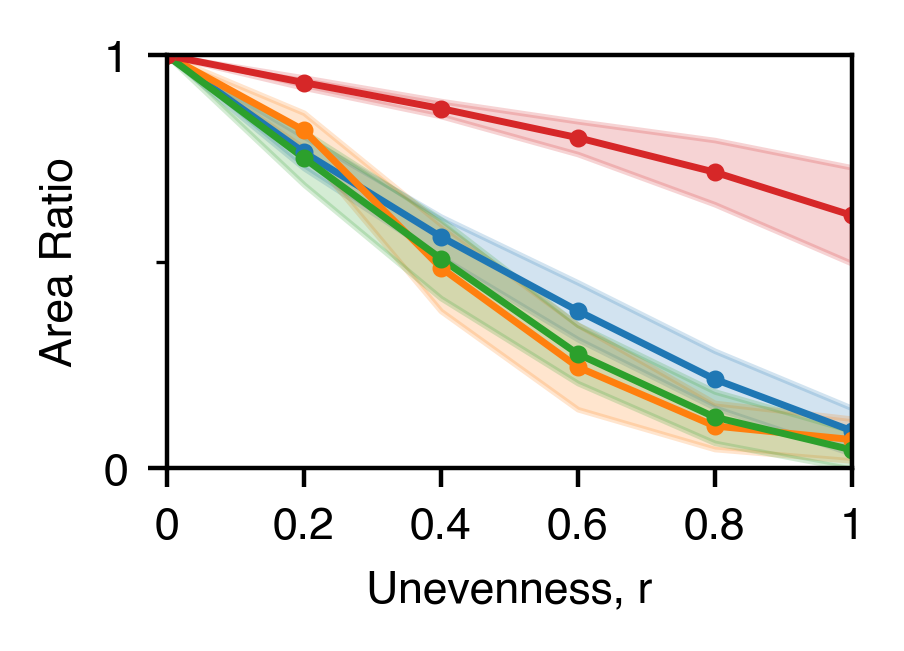

In [7]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots(1,1, figsize=(2.36,2.36*0.8), tight_layout=True, dpi=400)

nets = ["SK", "HU", "MAI", "MSI"]
color_dict = dict(zip(nets, cycle))

(master_arr, master_std) = thresh_arr[0]
for idx, arr in enumerate(master_arr.T):
    ax.plot(np.arange(6), arr, lw=1.25, label=nets[idx], c=color_dict[nets[idx]], zorder=0)
    ax.scatter(np.arange(6), arr, s=5, label=nets[idx], c=color_dict[nets[idx]],zorder=1)

    ax.fill_between(np.arange(6), (arr-master_std.T[idx]), (arr+master_std.T[idx]), 
                       color=color_dict[nets[idx]], alpha=0.2, zorder=-1)

    ax.set_xlabel("Unevenness, r", fontsize=8)
    ax.set_ylabel("Area Ratio", fontsize=8)
    ax.set_box_aspect(1/1.66)
    ax.set_xticks(ticks=[0,1,2,3,4,5])
    ax.set_xticklabels([0,0.2,0.4,0.6,0.8,1])
    ax.set_yticks(ticks=[0,1])
    ax.set_yticks(ticks=[0.5], minor=True)
    ax.set_yticklabels(list(map(str, [0,1])))
    ax.tick_params(axis='both', which='major', labelsize=8)

plt.xlim(0,5)
plt.ylim(0,1)

## Loading retrieval for varying accuracy cutoff

In [8]:
thresh_arr = []
threshs = aspace(0.45,0.99,0.005)
for thresh in threshs:
    d = {}
    names = ["SK", "HU", "MAI", "MSI"]
    c = 0
    for net in names:
        arr = []
        activities = np.array([0.3, 0.3, 0.3, 0.3, 0.3])
        activity_str = f"activity_a1=%s_a2=%s_a3=%s_a4=%s_a5=%s" % tuple(activities)
        PATH = f"interpolation_data/n=0/sector/{activity_str}"
        phase_space_dict = np.load(os.path.join(PATH, f"nettype={net}_phase_space.npy"), allow_pickle=True).item()

        (theta_min, theta_max) = phase_space_dict["theta"]
        (gamma_min, gamma_max) = phase_space_dict["gamma"]
        phase_space = phase_space_dict["phase_space"]
        phase_space[np.isnan(phase_space)] = 0
        cutoff = 0.8
        phase_space[phase_space < cutoff] = 0
        phase_space[phase_space > cutoff] = 1
        arr.append(int(sum(phase_space.ravel())))
        d[net] = int(sum(phase_space.ravel()))

    d_inter = {}
    for interpolation_step in [5]:
        d_inter[interpolation_step] = {}
        start_activities_set = np.array([0.3, 0.3, 0.3, 0.3, 0.3])
        end_activities_set = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
        num_interpolation_steps = 6
        activities_set = start_activities_set + (end_activities_set - start_activities_set)*interpolation_step/(num_interpolation_steps-1)
        activities_set = np.around(activities_set, decimals=2)
        perms = cyclic_permutation(activities_set)
        activity_iter = iter(perms)
        c = 0
        for i in range(2):
            for j in range(2):
                arr = []
                for idx, perm in enumerate(perms):
                    if idx >= 24:
                        break
                    activities = perm
                    activity_str = f"activity_a1=%s_a2=%s_a3=%s_a4=%s_a5=%s" % tuple(activities)
                    PATH = f"interpolation_data/n={interpolation_step}/{activity_str}"
                    phase_space_dict = np.load(os.path.join(PATH, f"nettype={names[c]}_phase_space.npy"), allow_pickle=True).item()

                    (theta_min, theta_max) = phase_space_dict["theta"]
                    (gamma_min, gamma_max) = phase_space_dict["gamma"]
                    phase_space = phase_space_dict["phase_space"]
                    phase_space[np.isnan(phase_space)] = 0
                    phase_space[phase_space < thresh] = 0
                    phase_space[phase_space > thresh] = 1
                    arr.append(int(sum(phase_space.ravel())))
                arr = np.divide(arr, d[names[c]])
                d_inter[interpolation_step][names[c]] = [np.mean(arr), np.std(arr)]
                c += 1

    master_arr = []
    master_std = []
    for interpolation_step, d_nets in d_inter.items():
        arr = []
        std_arr = []
        for net, [mean, std] in d_nets.items():
            arr.append(mean)
            std_arr.append(std)
        master_arr.append(arr)
        master_std.append(std_arr)

    master_arr = np.array(master_arr, dtype=float)
    master_std = np.array(master_std, dtype=float)

    thresh_arr.append((master_arr, master_std))
    
thresh_arr = np.array(thresh_arr).T


## Plotting retrieval for varying accuracy cutoff

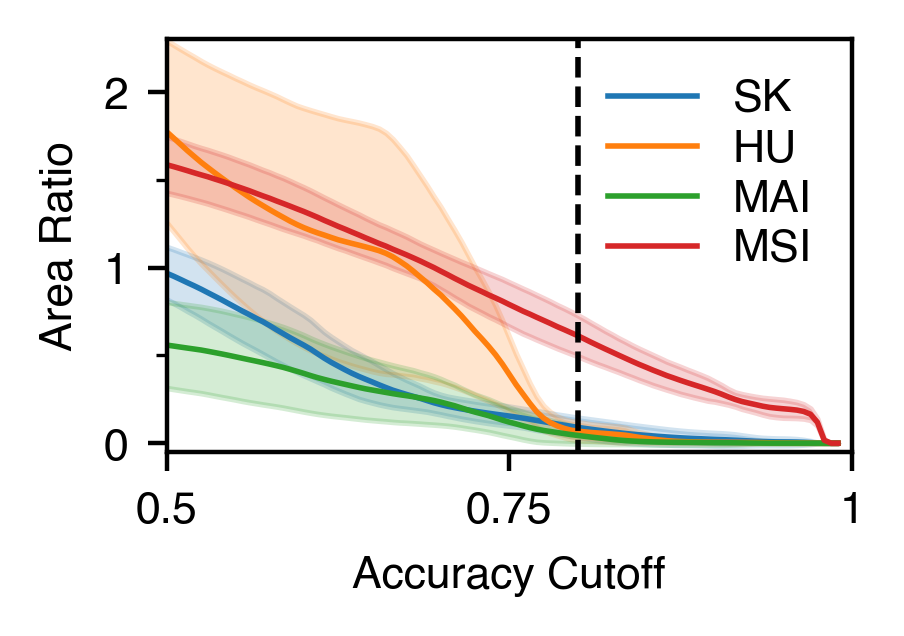

In [9]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots(1,1, figsize=(2.36,2.36*0.8), tight_layout=True, dpi=400)

nets = ["SK", "HU", "MAI", "MSI"]
color_dict = dict(zip(nets, cycle))
for k, c in enumerate(range(4)):
    temp = thresh_arr[c][0]
    [master_arr, master_std] = temp
    ax.plot(threshs, master_arr, lw=1, label=nets[k], c=color_dict[nets[k]])
    ax.fill_between(threshs, master_arr-master_std, master_arr+master_std, color=color_dict[nets[k]], alpha=0.2)
    ax.set_box_aspect(1/1.66)
    ax.set_xlabel("Accuracy Cutoff", fontsize=8)
    ax.set_ylabel("Area Ratio", fontsize=8)

    ax.set_xticks(ticks=[0.5,0.75,1])
    ax.set_xticklabels(list(map(str, [0.5,0.75,1])))
    ax.set_yticks(ticks=[0,1,2])
    ax.set_yticks(ticks=[0.5,1.5], minor=True)
    ax.tick_params(axis='both', which='major', labelsize=8)

ax.vlines(0.8, -10, 10, lw=1, ls='--', color='k')
ax.set_xlim(0.5,1)
ax.set_ylim(-0.05,2.3)


ax.legend(fontsize=8, frameon=False, labelspacing=0.2)